In [47]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplot
import geoplot as gplt
import matplotlib as mpl
import datetime

In [66]:
# load covid data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
conf = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
dead = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
recs = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [12]:
# load geodata
url = 'https://raw.githubusercontent.com/deldersveld/topojson/master/'

# china
china = gpd.read_file(url + 'countries/china/china-provinces.json')
china.loc[china['NAME_1'] == 'Nei Mongol','NAME_1'] = 'Inner Mongolia'
china.loc[china['NAME_1'] == 'Xinjiang Uygur','NAME_1'] = 'Xinjiang'
china.loc[china['NAME_1'] == 'Xizang','NAME_1'] = 'Tibet'
china.loc[china['NAME_1'] == 'Ningxia Hui','NAME_1'] = 'Ningxia'
china.rename(columns={'NAME_1' : 'geounit'}, inplace=True)

# world
world = gpd.read_file(url + 'world-countries.json')
world = world.drop(world.loc[world['geometry'].is_empty].index)
world.rename(columns = {'name' : 'geounit'}, inplace=True)
world.loc[world['geounit'] == 'United States of America','geounit'] = 'United States'

# europe
europe = gpd.read_file(url + 'continents/europe.json')
europe.drop(europe.loc[europe['geometry'].is_empty].index,inplace=True)
# remove Russie for now
europe.drop(europe.loc[europe['geounit']=='Russia'].index,inplace=True)
# make the UK
europe.loc[europe['geounit'] == 'England','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Scotland','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Wales','geounit'] = 'United Kingdom'
europe.loc[europe['geounit'] == 'Northern Ireland','geounit'] = 'United Kingdom'

# usa
usa = gpd.read_file(url + 'countries/united-states/us-albers.json')
usa = usa.drop(usa.loc[usa['geometry'].is_empty].index)
usa.rename(columns={'name' : 'geounit'},inplace=True)

# africa
africa = gpd.read_file(url + 'continents/africa.json')
africa.drop(africa.loc[africa['geometry'].is_empty].index,inplace=True)

# asia
asia = gpd.read_file(url + 'continents/asia.json')
asia.drop(asia.loc[asia['geometry'].is_empty].index,inplace=True)
# remove Russie for now
asia.drop(asia.loc[asia['geounit']=='Russia'].index,inplace=True)

# south america
samerica = gpd.read_file(url + 'continents/south-america.json')
samerica.drop(samerica.loc[samerica['geometry'].is_empty].index,inplace=True)

In [27]:
 set(conf.loc[conf['Country/Region'] == 'China', 'Province/State'].unique()) - set(china['geounit'].unique())

{'Hong Kong', 'Macau'}

In [72]:
def process_date(d):
    m,d,y = d.split('/')
    if len(m) < 2:
        m = '0' + m
    if len(d) < 2:
        d = '0' + d
    return '/'.join([m,d,y])

In [82]:
def rename_cols(df,ind):
    dct = dict(zip(list(df.columns[ind:]), [process_date(x) for x in list(df.columns[ind:])]))
    df.rename(columns=dct,inplace=True)

,id,geo_id,fips_state,geounit,iso_3166_2,census,pop_estimataes_base,pop_2010,pop_2011,pop_2012,pop_2013,pop_2014,geometry
0,0,0400000US04,04,Arizona,AZ,6392017,6392310,6411999,6472867,6556236,6634997,6731484,"POLYGON ((-109.04527 36.99904, -109.04527 36.9..."
1,1,0400000US05,05,Arkansas,AR,2915918,2915958,2922297,2938430,2949300,2958765,2966369,"POLYGON ((-94.04285 33.01925, -94.04312 33.079..."
2,2,0400000US06,06,California,CA,37253956,37254503,37336011,37701901,38062780,38431393,38802500,"MULTIPOLYGON (((-120.24846 33.99927, -120.2473..."
3,3,0400000US08,08,Colorado,CO,5029196,5029324,5048575,5119661,5191709,5272086,5355866,"POLYGON ((-104.05319 41.00142, -104.03928 41.0..."
4,4,0400000US09,09,Connecticut,CT,3574097,3574096,3579345,3590537,3594362,3599341,3596677,"POLYGON ((-71.79931 42.00807, -71.79686 41.928..."
5,5,0400000US11,11,District of Columbia,DC,601723,601767,605210,620427,635040,649111,658893,"POLYGON ((-77.11981 38.93428, -77.10072 38.949..."
6,6,0400000US13,13,Georgia,GA,9687653,9688681,9714464,9813201,9919000,9994759,10097343,"POLYGON ((-84.32192 34.98837, -84.12961 34.987..."
7,7,0400000US17,17,Illinois,IL,12830632,12831587,12840097,12858725,12873763,12890552,12880580,"POLYGON ((-87.80036 42.49193, -87.80036 42.490..."
8,8,0400000US18,18,Indiana,IN,6483802,6484192,6490308,6516560,6537632,6570713,6596855,"POLYGON ((-84.82028 39.10551, -84.83119 39.101..."
9,9,0400000US22,22,Louisiana,LA,4533372,4533479,4545581,4575972,4604744,4629284,4649676,"MULTIPOLYGON (((-88.86501 29.75264, -88.88983 ..."


In [94]:
conf['Province/State'].unique()

array([nan, 'British Columbia', 'New South Wales', 'Victoria',
       'Queensland', 'South Australia', 'From Diamond Princess',
       'Western Australia', 'Tasmania', 'Northern Territory', 'Ontario',
       'Alberta', 'Quebec', 'Washington', 'New York', 'California',
       'Massachusetts', 'Diamond Princess', 'Grand Princess', 'Georgia',
       'Colorado', 'Florida', 'New Jersey', 'Oregon', 'Texas', 'Illinois',
       'Pennsylvania', 'Iowa', 'Maryland', 'North Carolina',
       'South Carolina', 'Tennessee', 'Virginia', 'Arizona', 'Indiana',
       'Kentucky', 'District of Columbia', 'Nevada', 'New Hampshire',
       'Minnesota', 'Nebraska', 'Ohio', 'Rhode Island', 'Wisconsin',
       'Connecticut', 'Hawaii', 'Oklahoma', 'Utah', 'Kansas', 'Louisiana',
       'Missouri', 'Vermont', 'Alaska', 'Arkansas', 'Delaware', 'Idaho',
       'Maine', 'Michigan', 'Mississippi', 'Montana', 'New Mexico',
       'North Dakota', 'South Dakota', 'West Virginia', 'Wyoming',
       'Hubei', 'France', 'G

In [85]:
rename_cols(conf,4)
rename_cols(dead,4)
rename_cols(recs,4)

In [86]:
conf.loc[:,['Country/Region','03/12/20']].groupby('Country/Region').sum()

,03/12/20
Country/Region,
Afghanistan,7
Albania,23
Algeria,24
Andorra,1
Antigua and Barbuda,0
...,...
Uruguay,0
Uzbekistan,0
Venezuela,0


In [ ]:
def gen_date

In [14]:
def render_sub_frame(params=None): 
    # normalize colormap
    norm = mpl.colors.Normalize(vmin=params['color_min'], vmax=params['color_max'])
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=params['cmap']).cmap
    
    # sum numbers by country, take log10
    s = params['data'].loc[:,['Country/Region', params['date']]].groupby('Country/Region').sum()
    
    # merge w/ map data
    geodata = params['map_data'].copy()
    geodata['raw'] = np.zeros(geodata.shape[0])
    geodata['log10'] = np.zeros(geodata.shape[0])
    
    for country in s.index:
        geodata.loc[geodata['geounit'] == country,'log10'] = np.log10(s.loc[country])
        geodata.loc[geodata['geounit'] == country,'raw'] = s.loc[country]
        
    gplot.choropleth(geodata,
                     hue='log10',
                     cmap=cmap,
                     ax=params['ax'],
                     norm=norm,
                     legend = True,
                    )
    
    if params['annot']:
        for ix,row in geodata.iterrows():
            centroid = row['geometry'].centroid.coords
            x0 = centroid[0][0]
            y0 = centroid[0][1]
            params['ax'].text(x0, y0, int(row[raw_feature]), fontsize=10)
    
    # derive date and time for plot title
    str_date = params['date']
    params['ax'].set_title('COVID19 '+ params['title_annot'] +' over time ' + date)
    #del geodata

In [ ]:
def plot_by_region(data=None,
                   start_date=None,
                   end_date=None,
                   dims=(12,12),
                   dpi=150,
                   annot=True,
                   save_path=None,
                   mode='global',
                   country=None,
                   params=None,
                   verbose=True):
    ''' wrapper around render_subframe_by_country and render_subframe_by_state'''
    
    dates = np.sort(data['date'].unique())
    if start_date == None:
        start_date = dates[0]
        
    if end_date == None:
        end_date = dates[-1]
        
    dates = dates[np.where((dates >= start_date) & (dates <= end_date))]
    n_plots = len(params)
    
    for date in dates:
        for time in range(0,2500,timestep):
            # prepare the date+time number
            if time == 0:
                t = '0000'
            elif time < 1000:
                t = '0' + str(time)
            else:
                t = str(time)
            
            this_time = int(str(date) + t)
            fig,axs = plt.subplots(n_plots, figsize=dims)
        
            ax_ind = 0
            for fdict in params:
                fdict['time_point'] = this_time
                fdict['annot'] = annot
                
                if n_plots == 1:
                    fdict['ax'] = axs
                else:
                    fdict['ax'] = axs[ax_ind]
                    ax_ind += 1
            
                # render map
                if mode == 'global':
                    fdict['data'] = data
                    render_sub_frame(params=fdict)
                elif mode == 'country': 
                    fdict['data'] = data.loc[data['country'] == country].copy()
                    fdict['data'].rename(columns={'country' : 'cnt', 'region' : 'country'}, inplace=True)
                    render_sub_frame(params=fdict)
                else:
                    pass
            
            fig.tight_layout()
            
            if not os.path.exists(save_path):
                os.mkdir(save_path)
                if verbose:
                    print('Created %s' %save_path)
            
            fname = save_path + str(this_time) + '.png'
            if verbose:
                print(fname)
            
            plt.savefig(fname, dpi=FIG_DPI)
            fig.clf()
            plt.close()
        
            # maybe running into RAM problems because creating too many figures
            gc.collect()

In [124]:
conf.head(n=100)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,117,129,149,149,197,238,428,566,673,790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,10,12,23,33,38,42,51,55,59
96,NaN,Cyprus,35.1264,33.4299,0,0,0,0,0,0,...,2,3,6,6,14,26,26,33,46,49
97,NaN,Brunei,4.5353,114.7277,0,0,0,0,0,0,...,1,1,11,11,37,40,50,54,56,68
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,267,366,442,568,572,643,904,1076,1014


In [15]:
plot_data = conf.loc[conf['Country/Region'] == 'China']

In [84]:
plot_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,267,366,442,568,572,643,904,1076,1014
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,0,173,220,328,421,525,732,967,1706,2495
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,0,144,177,221,282,340,426,557,698,751
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,0,92,95,108,123,138,164,197,218,218
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,45,46,46,46,46,46,46,47,47,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,...,0,0,0,0,5,6,12,29,39,46
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,0,0,0,0,3,5,5,5,5
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,3,5


In [106]:
state_ind = plot_data['Province/State'].apply(lambda x: ',' not in x)

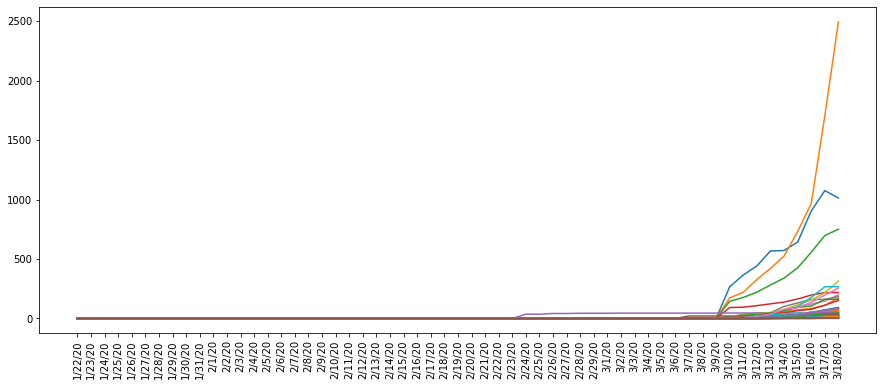

In [115]:
fig,ax=plt.subplots(figsize=(15,6))

plt.plot(plot_data[state_ind].iloc[:,4:].transpose())
#plt.legend(plot_data[state_ind]['Province/State'])
_ = plt.xticks(rotation=90)

In [ ]:
plt.plot(conf.groupby('Province/State').sum().loc['Alameda County, CA'].iloc[2:])

In [ ]:
conf.groupby('Province/State').sum()